In [2]:
import os
os.chdir('..')  # Mueve el directorio de trabajo un nivel arriba    ]


#

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.signal import find_peaks
import scipy.signal.windows as win
import scipy as sp
import warnings
import re
from ipywidgets import interact,widgets
from scipy.optimize import curve_fit
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.misc import derivative
from functions_master import *
import warnings

# Suprimir FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Configuración desde el archivo txt (simulada aquí como un diccionario)
config = {
    'figure.constrained_layout.use': True,
    'figure.figsize': (5.4, 3.2),
    'figure.titlesize': 'small',
    'figure.labelsize': 'small',
    'font.size': 10,
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.texsystem': 'lualatex',
    'pgf.rcfonts': False,
    'pgf.preamble': r'\usepackage{siunitx,fontspec}\setmainfont{Times New Roman}',
    'lines.linewidth': 1,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 4,
    'legend.frameon': False,
    'legend.markerscale': 0.8,
    'legend.fontsize': 'small',
    'legend.title_fontsize': 'small',
    'legend.handlelength': 1.5,
    'legend.handletextpad': 0.2,
    'xtick.top': True,
    'xtick.major.size': 5,
    'xtick.major.width': 0.8,
    'xtick.minor.width': 0.8,
    'xtick.minor.size': 3,
    'xtick.labelsize': 'small',
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.major.size': 5,
    'ytick.major.width': 0.8,
    'ytick.minor.width': 0.8,
    'ytick.minor.size': 3,
    'ytick.labelsize': 'small',
    'ytick.direction': 'in',
    'axes.linewidth': 0.8,
    'axes.axisbelow': False,
    'axes.labelsize': 'medium',
    'axes.labelpad': 2,
    'figure.constrained_layout.h_pad': 0.02,
    'figure.constrained_layout.w_pad': 0.01,
    'figure.constrained_layout.hspace': 0.02,
    'figure.constrained_layout.wspace': 0.02,
    'svg.fonttype': 'none'
}

# Aplicar la configuración
plt.rcParams.update(config)

In [5]:
x1,x2 = 0.15,1.05

path_air1 = r'C:\Users\esteb\Escritorio\physics\mestrado_thz_physics\paper_window\Air+Water'
archivos = os.listdir(path_air1)

labels = [extraer_humedad(nombre_archivo) for nombre_archivo in archivos]
# Filtrar solo archivos (excluyendo carpetas)
archivos = [os.path.join(path_air1, archivo) for archivo in archivos if os.path.isfile(os.path.join(path_air1, archivo))]

In [6]:
# Parameters for fitting
nu11, nu21 = 0.4, 0.7
p01 = [1,0.25,0.556,0.01]
nu12, nu22 = 0.6, 0.9
p02=[1,0.25,0.75,0.01]
nu13, nu23 = 0.9, 1.075
p03=[1,0.25,0.98,0.01]

initial_seed = [p01,p02,p03]
nus1 = [nu11,nu12,nu13]
nus2 = [nu21,nu22,nu23]

In [7]:
nu_filtradas1, ref = extrac_data_freq(x1,x2,os.path.join(path_air1, archivos[-1]))
# f = plt.figure(figsize=(15,5))

nu1, nu2 = 0.9, 1.075

parameters = []
parameters_hum = np.zeros((len(archivos)-1,4))

# colors = ['b','r','k','g','c']
kk = 0

for kk in range(len(nus1)):
    cont = 0
    parameters_hum = np.zeros((len(archivos)-1,4))

    for j,arc in enumerate(archivos):

        if j!=len(archivos)-1:
            nu_filtradas1, fourier1 = extrac_data_freq(x1,x2,os.path.join(path_air1, arc))
            filter_omega = (nu_filtradas1 > nus1[kk]) & (nu_filtradas1 < nus2[kk])
            params = fit_trans_model(nu_filtradas1,np.abs(fourier1/ref),nus1[kk], nus2[kk],p0=initial_seed[kk])
            parameters_hum[cont,0] = params[0]
            parameters_hum[cont,1] = params[1]
            parameters_hum[cont,2] = params[2]
            parameters_hum[cont,3] = params[3]

            cont+= 1

    parameters.append(parameters_hum)

In [8]:
def anim2(τs,τc,τp,a):

    
    f = plt.figure(figsize=(15,5))

    plt.subplot(121)
    for j,arc in enumerate(archivos):
        
        
        t, y = extrac_data_time(os.path.join(path_air1, arc))


        plt.plot(t, (y)/max(y),label = f'{labels[j]} %')
    # print(np.argmax(y))
        # plt.xlabel('t [ps]')
    # Constantes
    τs = τs*1e-14*1e12  # en segundos
    τc = τc*1e-14*1e12  # en segundos
    τp = τp*1e-15*1e12 # en segundos
    t_dis = (t-t[np.argmax(y)])*1e-1
    ethz = E_THz(t_dis,τs,τc,τp)*np.cos(1*t*a)

    plt.plot(t,ethz.values/max(ethz.values),'k',label='THz field Vacuum')
    plt.xlim(min(t),400)
    plt.xlabel('t [ps]')
    plt.ylabel('E [t]')
    plt.legend(loc='upper right')

    plt.subplot(122)
    N = 2**12
    k = 15
    nu = sp.fft.fftfreq(N, 1/30)
    fourier = FourierT(ethz.values,N)[1:len(nu)//k]
    nu = nu[1:len(nu)//k]
    xmin, xmax = x1,x2
    mask = (nu >= xmin) & (nu <= xmax)
    nu_filtradas = nu[mask]
    fourier = fourier[mask]

    plt.plot(nu_filtradas,np.abs(fourier)/max(np.abs(fourier)),'k')

    for j,arc in enumerate(archivos):

        nu_filtradas1, fourier1 = extrac_data_freq(x1,x2,os.path.join(path_air1, arc))
        plt.plot(nu_filtradas1, np.abs(fourier1)/max(np.abs(fourier1)),label = f'{labels[j]} %')
        plt.xlabel('$\omega$ [THz]')
        plt.ylabel(r'Absolute value FFT')
        #plt.yscale('log')

    f = plt.figure(figsize=(15,5))

    nu_filtradas1, ref = extrac_data_freq(x1,x2,os.path.join(path_air1, archivos[-1]))
    colors = ['b','r','k','g','c']
    kk = 0
    
    
    for j,arc in enumerate(archivos):

        if j!=len(archivos)-1:
            nu_filtradas1, fourier1 = extrac_data_freq(x1,x2,os.path.join(path_air1, arc))
            plt.subplot(121)
            signal_exp = np.abs(fourier1/ref)
            plt.plot(nu_filtradas1, signal_exp ,color=colors[kk],label = f'{labels[j]} %')
            plt.ylabel(r'Transmitance')
            plt.xlabel('$\omega$ [THz]')
            
            plt.subplot(122)
            signal = concat_trans(nu_filtradas1,parameters,j)
            dist = signal[0]-signal_exp[0]  
            plt.plot(nu_filtradas1,signal-dist,color=colors[kk],label = f'{labels[j]} % fit')

            kk+=1

    # plt.plot(nu_filtradas1, np.abs(fourier1)/max(np.abs(fourier1)),label = f'{labels[-1]} %')
    
    
    plt.legend()



opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        τs= widgets.FloatSlider(min=0,max=5,value=5,step=0.001,**opc),
        τc= widgets.FloatSlider(min=0,max=14,value=0.420,step=0.01,**opc),
        τp= widgets.FloatSlider(min=0,max=500,value=48,step=1,**opc),
        a= widgets.FloatSlider(min=0,max=5,value=1.7,step=0.01,**opc)
        )

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='τs', max=5.0, readout_forma…

<function __main__.anim2(τs, τc, τp, a)>

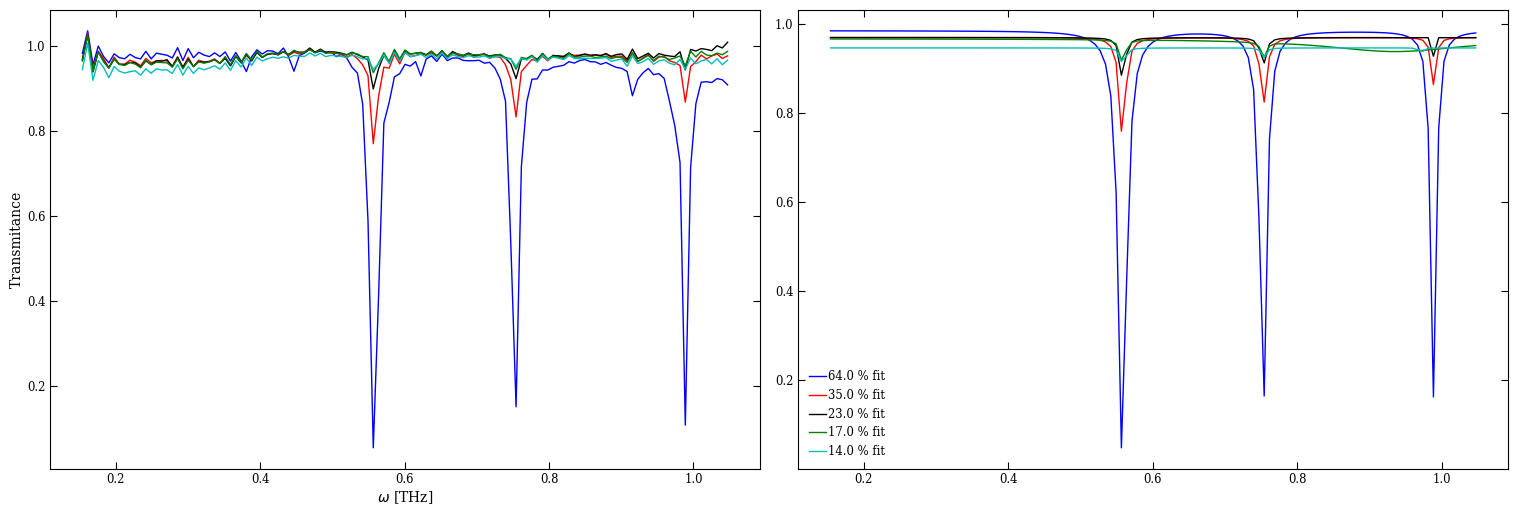

In [9]:
f = plt.figure(figsize=(15,5))

transmitances = []
nu_filtradas1, ref = extrac_data_freq(x1,x2,os.path.join(path_air1, archivos[-1]))
colors = ['b','r','k','g','c']
kk = 0


for j,arc in enumerate(archivos):

    if j!=len(archivos)-1:
        nu_filtradas1, fourier1 = extrac_data_freq(x1,x2,os.path.join(path_air1, arc))
        plt.subplot(121)
        signal_exp = np.abs(fourier1/ref)
        plt.plot(nu_filtradas1, signal_exp ,color=colors[kk],label = f'{labels[j]} %')
        plt.ylabel(r'Transmitance')
        plt.xlabel('$\omega$ [THz]')
        
        plt.subplot(122)
        signal = concat_trans(nu_filtradas1,parameters,j)
        dist = signal[0]-signal_exp[0]  
        transmitances.append(signal-dist)
        plt.plot(nu_filtradas1,signal-dist,color=colors[kk],label = f'{labels[j]} % fit')

        kk+=1

# plt.plot(nu_filtradas1, np.abs(fourier1)/max(np.abs(fourier1)),label = f'{labels[-1]} %')


plt.legend()


In [11]:
t, y = extrac_data_time(os.path.join(path_air1, archivos[0]))
    # plt.plot(t, (y)/max(y),label = f'{labels[j]} %')
# Constantes
# τs = 0.333*1e-14*1e12  # en segundos
# τc = 0.680*1e-14*1e12  # en segundos
# τp = 39*1e-15*1e12 # en segundos
τs = 5*1e-14*1e12  # en segundos
τc = 0.420*1e-14*1e12  # en segundos
τp = 48*1e-15*1e12 # en segundos
t_dis = (t-t[np.argmax(y)])*1e-1
ethz = E_THz(t_dis,τs,τc,τp)*np.exp(1j*1.710*t)

N = 2**12
n_k = 15
nu = sp.fft.fftfreq(N, 1/30)

# fouriert_thz = FourierT(ethz.values,N)[1:len(nu)//k]
fouriert_thz_full = FourierT(ethz.values,N)
nu1 = nu[1:len(nu)//n_k]
xmin, xmax = x1,x2
mask = (nu1 >= xmin) & (nu1 <= xmax)
nu_filtradas = nu1[mask]
# fouriert_thz = fouriert_thz[mask]

# Calcular la cantidad de puntos que se necesitan para completar el tamaño original
puntos_izquierda = np.where(nu == nu_filtradas[0])[0][0]
puntos_derecha = len(nu) - (puntos_izquierda + len(nu_filtradas))

C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


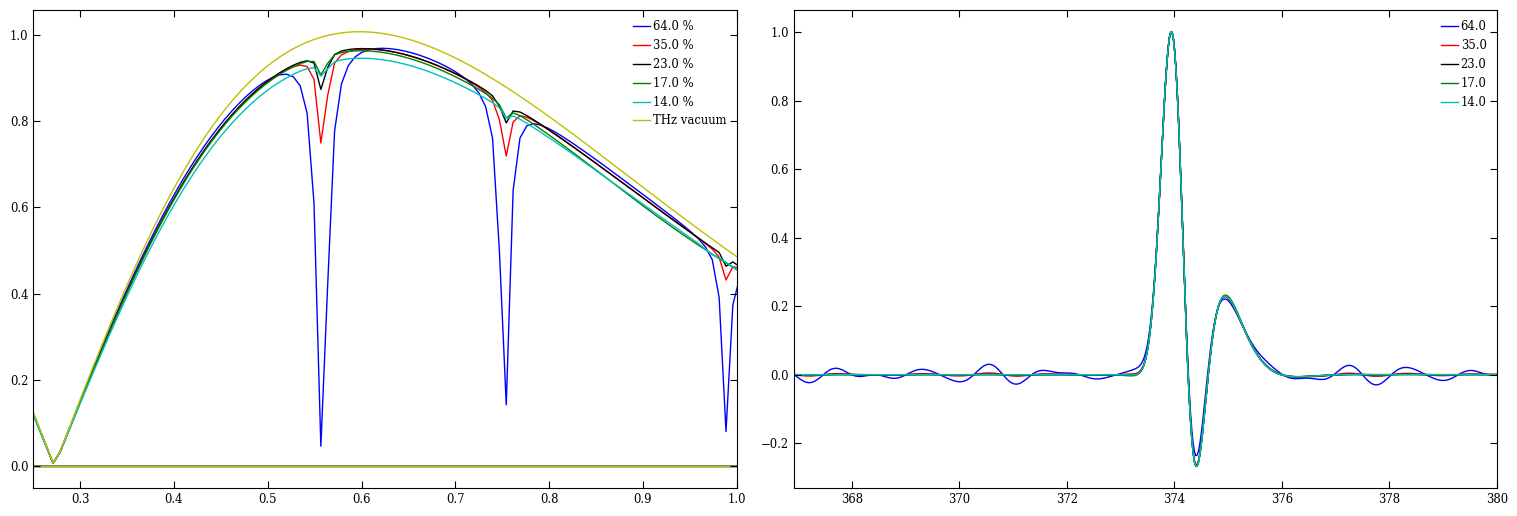

In [12]:
f = plt.figure(figsize=(15,5))
plt.subplot(121)

transmitances_new = []
for cont,transm in enumerate(transmitances):

    k_new = np.pad(transm, (puntos_izquierda, puntos_derecha), mode='constant', constant_values=(transm[0],transm[-1]))
    transmitances_new.append(k_new)
    # print(cont)
    plt.plot(nu,np.abs(fouriert_thz_full)/max(np.abs(fouriert_thz_full))*k_new ,color=colors[cont],label=f'{labels[cont]} %')
    plt.xlim(0.25,1)

plt.plot(nu,np.abs(fouriert_thz_full)/max(fouriert_thz_full),'y',label='THz vacuum')
plt.legend(loc='upper right')
#plt.xlim(0,2)


plt.subplot(122)
time_array = np.linspace(min(t),max(t),N)
plt.plot(time_array,FourierI(fouriert_thz_full,N)/max(FourierI(fouriert_thz_full,N)),'k')


for cont,k in enumerate(transmitances_new):
    time_domain = FourierI(fouriert_thz_full*k,N)
    plt.plot(time_array,time_domain/max(time_domain),color=colors[cont],label=labels[cont])
    plt.xlim(min(time_array),380)

plt.legend()

In [13]:
def E(t,a,w):
    return np.exp(-a*t**2)*np.exp(-1j*w*t)

def anim2(a,w):

    
    f = plt.figure(figsize=(15,5))


    t, y = extrac_data_time(os.path.join(path_air1, archivos[0]))

    plt.subplot(121)
    #plt.plot(t, y/max(y),label = f'{labels[0]} % experimental data')
    plt.xlabel('t [ps]')
    t_label = (t-t[np.argmax(y)])
    E_field = np.exp(-a*t_label**2)*np.exp(1j*w*t)
    plt.plot(t,np.real(E_field)/max(np.abs(E_field)),'k',label='theoretical')
    plt.legend()
    plt.xlim(min(t),400)

    plt.subplot(122)
    N = 2**12
    k = 15
    nu1 = sp.fft.fftfreq(N, 1/30)
    fourier = FourierT(E_field.values,N)
    # nu = nu1[1:len(nu)//k]
    # xmin, xmax = x1,x2
    # mask = (nu >= xmin) & (nu <= xmax)
    # nu_filtradas = nu[mask]
    # fourier = fourier

    new_fiedl = fourier/max(np.abs(fourier))*transmitances_new[0]

    plt.plot(nu1,np.abs(new_fiedl),'o',color=colors[0],label='Theoretical')
    nu_filtradas1, fourier1 = extrac_data_freq(x1,x2,os.path.join(path_air1, archivos[0]))
    plt.plot(nu_filtradas1, np.abs(fourier1)/max(np.abs(fourier1)),label = f'{labels[0]} % Experimental')
    plt.xlim(min(nu_filtradas1),1)
    plt.xlabel('$\omega$ [THz]')
    plt.legend()


    f = plt.figure(figsize=(15,5))
    time_array = np.linspace(min(t),max(t),N)
    plt.plot(time_array,FourierI(new_fiedl,N)/max(FourierI(new_fiedl,N)),'k',label='Theoretical pulse with air+water')
    #plt.plot(t,np.real(E_field)/max(np.abs(E_field)),'r',label='Theoretical pulse without air')
    plt.xlim(min(t),400)
    plt.xlabel('t [ps]')
    plt.legend()



opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        a= widgets.FloatSlider(min=0,max=5,value=1.258,step=0.001,**opc),
        w= widgets.FloatSlider(min=0,max=14,value=3.540,step=0.01,**opc),
        )

interactive(children=(FloatSlider(value=1.258, continuous_update=False, description='a', max=5.0, readout_form…

<function __main__.anim2(a, w)>